# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, it's time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:

- Use sampling techniques to address a class imbalance problem within a dataset 
- Create a visualization of ROC curves and use it to assess a model

## Predicting credit card fraud


The following cell loads all the functions you will be using in this lab. All you need to do is run it: 

In [ ]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Use Pandas to load the compressed CSV file, `'creditcard.csv.gz'`. 

> Note: You need to pass an additional argument (`compression='gzip'`) to read_csv() in order to load compressed CSV files. 

In [ ]:
# Load a compressed csv file
df = pd.read_csv('creditcard.csv.gz')

# Print the first five rows of data
df.head()

## Preview the class imbalance

Did you notice that the dataset has 31 columns? The first is a time field followed by columns V1 - V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary `'Class'` flag. This last column, `'Class'`, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is: 

In [ ]:
# Investigating poptential class imbalence
# 1. Identify target feature
target = 'Class'
# 2. Print the number of fraudulent/infraudulent purchases
print('Normalized counts: \n')
for e in [x for x in enumerate(df[target].value_counts(normalize=True))]:
    print(f'{e[0]}\t{e[1]*100:.4}%')

## Define the predictor and target variables

Define `X` and `y` and perform a standard train-test split. Assign 25% to the test set and `random_state` to 0. 

In [ ]:
# Your code here
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Find the class imbalance in the training and test sets: 

In [ ]:
# Training set
print('TRAIN SET:\n')

for e in [x for x in enumerate(y_train.value_counts(normalize=True))]:
    print(f'{e[0]}\t{e[1]*100:.4}%')
# Test set
print('\nTEST SET:\n')
for e in [x for x in enumerate(y_test.value_counts(normalize=True))]:
    print(f'{e[0]}\t{e[1]*100:.4}%')

## Create an initial model

As a baseline, train a vanilla logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

In [ ]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear') 
baseline = logreg.fit(X_train, y_train)

# Probability scores for test set
y_score = baseline.decision_function(X_test)

# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print(f' AUC: {auc(fpr, tpr)}')

# Plot the ROC curve
#plt.figure(figsize=(10, 8))
from sklearn.metrics import plot_roc_curve
plot_roc_curve(baseline, X_test, y_test);

Use scikit-learn's `plot_confusion_matrix` function to plot the confusion matrix of the test set: 

In [ ]:
# Plot confusion matrix of the test set 
plot_confusion_matrix(baseline, X_test, y_test);

## Tune the model 

Try some of the various techniques proposed to tune your model. Compare your models using AUC and ROC curve.

In [ ]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)
    print(model_log) # Preview model params

    # Predict
    y_hat_test = None # I don't think we need this

    y_score = model_log.decision_function(X_train)

    fpr, tpr, thresholds = roc_curve(y_train, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### SMOTE

Use the `SMOTE` class from the `imblearn` package in order to improve the model's performance on the minority class. 

In [ ]:
# Previous original class distribution
print('-'*40)
print('\tORIGINAL TRAIN DATA')
print('-'*40)
print(y_train.value_counts())
print('- '*20)
for e in [x for x in enumerate(y_train.value_counts(normalize=True))]:
    print(f'{e[0]}\t{e[1]*100:.4}%')
print('-'*40)

# Fit SMOTE to training data
from imblearn.over_sampling import SMOTE

X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_sample(X_train, y_train)

# Fit SMOTE to training data
from imblearn.combine import SMOTETomek
X_train_resampled2, y_train_resampled2 = SMOTETomek(random_state=42).fit_sample(X_train, y_train)

# Preview synthetic sample class distribution
print('-'*40)
print('\tSMOTE TRAIN DATA')
print('-'*40)
print(pd.Series(y_train_resampled).value_counts())
print('- '*20)
for e in [x for x in enumerate(y_train_resampled.value_counts(normalize=True))]:
    print(f'{e[0]}\t{e[1]*100:.4}%')
print('-'*40)

print('-'*40)
print('\tSMOTETomek TRAIN DATA')
print('-'*40)
print(pd.Series(y_train_resampled2).value_counts())
print('- '*20)
for e in [x for x in enumerate(y_train_resampled2.value_counts(normalize=True))]:
    print(f'{e[0]}\t{e[1]*100:.4}%')
print('-'*40)

In [ ]:
f'{((213233-212457)/213233)*100}%'

Similar to what you did above, build models with this resampled training data: 

In [ ]:
# Now let's compare a few different regularization performances on the dataset
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
#names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(C_param_range))

plt.figure(figsize=(10, 8))

# Write a for loop that builds models for each value of C_param_range, prints the AUC and plots the ROC
for n, c in enumerate(C_param_range):
    # Fit the model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train_resampled, y_train_resampled)
    # Calculate probability scores
    y_score = model_log.decision_function(X_train_resampled)
    # Get rates: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_train_resampled, y_score)
    # Print the details of the model
    print(model_log)
    print(f'AUC for {c}: {auc(fpr, tpr)}')
    print('-'*50)
    # Plot the roc curve
    plt.plot(fpr, tpr, color=colors[n], label=f'ROC curve Normalization Weight: {c}')
    

lw=2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Something wrong here? 
Describe what is misleading about the AUC score and ROC curves produced by this code:

In [ ]:
####### dont do this, DO NOT ALTER TEST DATA




# Previous original class distribution
print(y.value_counts()) 
X_resampled, y_resampled = SMOTE().fit_sample(X, y) 
# Preview synthetic sample class distribution
print('---------------------------------')
print(pd.Series(y_resampled).value_counts()) 

# Split resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('----------------------------------------------')
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Your response here

## Summary

In this lab, you got some hands-on practice tuning logistic regression models. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.

In [1]:
import pandas as pd

# Load a compressed csv file
data = pd.read_csv('creditcard.csv.gz')

# Identify target feature
target = 'Class'

# Investigating poptential class imbalence
  # Print the number of fraudulent/infraudulent purchases
print('Normalized counts: \n')
for e in [x for x in enumerate(data[target].value_counts(normalize=True))]:
    print(f'{e[0]}\t{e[1]*100:.4}%')

Normalized counts: 

0	99.83%
1	0.1727%


In [3]:
def check_model(current_model, 
                data=data, 
                target=target, 
                test_size=.20, 
                random_state=42, 
                class_imbalance_method=None, 
                use_test_data=False, 
                show_thresholds_table=False, 
                show_classification_report=False, 
                display_labels=None):
    """   
    Uses sklearn.model_selection.train_test_split to divide data into train and test sets, 
    sklearn.preprocessing.StandardScaler to scale data,
    imblearn.over_sampling.SMOTE to create synthetic data if specified, 
    .fit() to instantiated sklearn.linear_model.LogisticRegression current_model
    outputs model results for training data, unless specified otherwise with use_test_data=True
    
    Output
    ---------- 
    Plots Confusion matrix and ROC curve,
    (optional) Thresholds, FPRs, TPRs, & AUC Stats Table,
    (optional) Classification Report
    
    
    Parameters
    ----------
 
    current_model : variable of instantiated sklearn.linear_model.LogisticRegression model. 
    
    data : pandas data frame, default=data
    
    target : string or variable set to a string, default=target
    
    test_size : a sklearn.model_selection.train_test_split parameter: float or int, default=.20
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples.
    
    random_state : int or RandomState instance, default=42
        Controls the shuffling applied to the data before applying the split.
        Pass an int for reproducible output across multiple function calls.

    class_imbalance_method : {'SMOTE', 'Smote-NC', 'SMOTETomek', 'None'}, default=None
        Optional way of handling class imbalance problem. 
        SMOTE - Synthetic Minority Over-sampling Technique 
        
            "Smote oversampling technique only works for the dataset with all continuous features. 
            For a dataset with categorical features, we have a variation of Smote, which is Smote-NC 
            (Nominal and Continuous). 
            Smote can also be used for data with categorical features, by one-hot encoding but it may result 
            in an increase in dimensionality. Label Encoding can also be used to convert categorical to numerical, 
            but after smote it may result in unnecessary information. This is why we need to use SMOTE-NC when we 
            have cases of mixed data. Smote-NC can be used by denoting the features that are categorical, and 
            Smote would resample the categorical data instead of creating synthetic data." (Kumar, "7 Over 
            Sampling techniques to handle Imbalanced Data", 
            https://towardsdatascience.com/7-over-sampling-techniques-to-handle-imbalanced-data-ec51c8db349f)
        
        SMOTETomak - combination of SMOTE and Tomek Links
        
            "SMOTE is an oversampling technique and creates new minority class synthetic samples, and Tomek Links 
            is an undersampling technique
            
            For an imbalanced dataset, first SMOTE is applied to create new synthetic minority samples to get a 
            balanced distribution. Further, Tomek Links is used in removing the samples close to the boundary of 
            the two classes, to increase the separation between the two classes." (Kumar, "Stop using SMOTE to 
            handle all your Imbalanced Data", 
            https://towardsdatascience.com/stop-using-smote-to-handle-all-your-imbalanced-data-34403399d3be)
    
    use_test_data : boolean True or False, default=False
        determines the data used to asses model performance
    
    show_thresholds_report : boolean True or False, default=False
        Print table with AUC score, Thresholds, FPR's and TPR's
    
    show_classification_report : boolean True or False, default=False
        Build a text report showing the main classification metrics.
    
    display_labels : dict, list or 'None', default=None
        By default the function will set display_labels=sorted(set(y_true.values)). This will display labels as 
        they appear within the dataframe.
        If the target is binary the labels can be changed to more descriptive labels. 
        example: ['Healthy', 'HeartDisease']

    """
    # Imports for function
    import matplotlib.pyplot as plt
    %matplotlib inline
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from imblearn.over_sampling import SMOTE
    from imblearn.combine import SMOTETomek
    from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
        precision_score, recall_score, accuracy_score, f1_score, log_loss,\
        roc_curve, roc_auc_score, classification_report, plot_roc_curve, auc

    
    # 1. Separate data into features and target 
    X = data.drop(target, axis = 1)
    y = data[target]

    
    # 2. Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    
    # 3. Scale the data  
    #    PIPELINE when using CROSS VALIDATION so no data leakage, dont know how yet, update later
    #    a. Instantiate and fit
    scaler = StandardScaler()
    scaler.fit(X_train)
    #    b. Transform X_train and X_test
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)
    
    
    # Optional Synthetic Data: use SMOTE or SMOTETomek to compensate for class imbalance
    # Instantiate, fit and assign new variables 
    if class_imbalance_method == 'SMOTE':
        X_resampled, y_resampled = SMOTE(random_state=random_state).fit_sample(X_train_sc, y_train)
    elif class_imbalance_method == 'SMOTETomek':
        X_resampled, y_resampled = SMOTETomek(random_state=random_state).fit_sample(X_train_sc, y_train)
 

    # 4. Fit current_model 
    if class_imbalance_method == None:
        fit_model = current_model.fit(X_train_sc, y_train) 
    else: 
        fit_model = current_model.fit(X_resampled, y_resampled) 
    
    
    # 5. Test or Train data  
    if use_test_data == False:
        if class_imbalance_method == None:
            X_true = X_train_sc
            y_true = y_train
        else:
            X_true = X_resampled
            y_true = y_resampled
    else:
        X_true = X_test_sc
        y_true = y_test
    
    
    ######################################################################
    # OUTPUTS                                                            #
    ######################################################################
    
    
    # Optional Thresholds Table
    if show_thresholds_table == True:
        # a. Calculate the probability scores
        y_score = fit_model.decision_function(X_true)
        # b. Assign variables
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        thresh_fp_tp = list(zip(thresholds, fpr, tpr))
        these_to_print = [f'THRESHOLD: {e[0]:.2f} | FPR: {e[1]:.2%}, TPR:{e[2]:.2%}' for e in thresh_fp_tp]        
        auc = auc(fpr, tpr)
        # c. Print the table
        print('-'*54)
        print('\t\t  THRESHOLD STATS')
        print('-'*54)
        print(f'AUC: {auc}')
        print('- '*23)
        for element in these_to_print:
            print(element)
        print('-'*54)
        
        
    # Optional Classification Report
    if show_classification_report == True:
        # a. Calculate the accuracy score for our model 
        y_pred = current_model.predict(X_true) 
        # b. Print classification report
        cr = classification_report(y_true, y_pred, digits=4)
        print('-'*54)
        print('\t\t CLASSIFICATION REPORT')
        print('-'*54)
        print(cr)
        print('-'*54)
    
 
    ######################################################################
    # VISUALIZATIONS                                                     #
    ######################################################################

    
    # Figure set up
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5)) 
    fig.suptitle(f'Model: {current_model}', color='tab:blue', size=14)
     
        
    # Left  
    axes[0].set_title("Confusion Matrix", size=15)  
    axes[0].grid(False)
    if display_labels == None:
        display_labels = sorted(set(y_true.values))
    #else:
    #    display_labels = display_labels
    plot_confusion_matrix(current_model, X_true, y_true, 
                          cmap=plt.cm.Blues, 
                          ax=axes[0], 
                          display_labels=display_labels)
        
    # Right 
    axes[1].set_title("ROC Curve", size=15)
    plot_roc_curve(current_model, X_true, y_true, ax=axes[1]);
    
    ########### NOTES:
    # model_log_loss?
    # 
    

In [2]:
from sklearn.linear_model import LogisticRegression
# set a model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

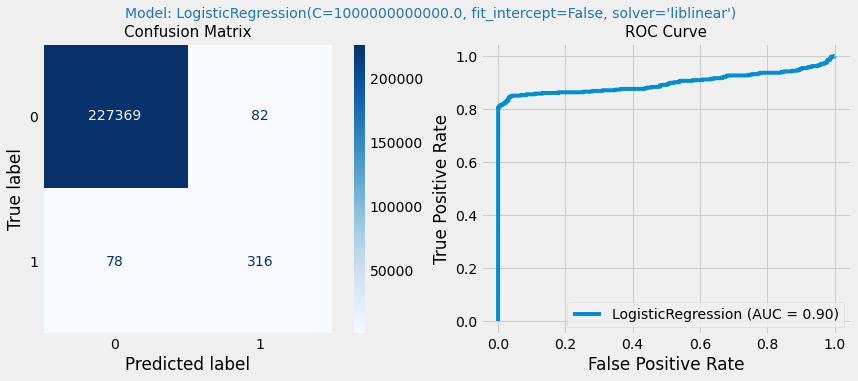

In [4]:
# check_model 
check_model(logreg)

In [ ]:
# check_model - use class_imbalance_method='SMOTE'
check_model(logreg, class_imbalance_method='SMOTE')

In [5]:
# set a model with adjusted class_weight dict
logreg_cw = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', 
                                class_weight={0: round(data[target].value_counts(normalize=True)[1],6), 1: round(data[target].value_counts(normalize=True)[0],6)})

In [ ]:
check_model(logreg_cw)

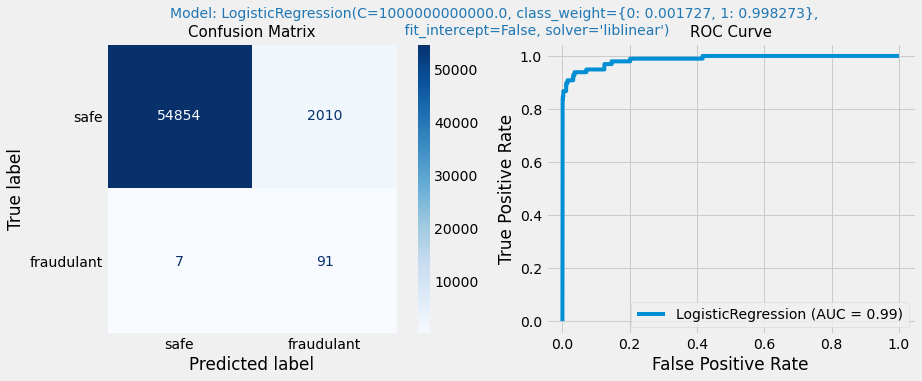

In [10]:
# check model logreg_cw on test_data - give more evident labels, print classification report and threshold table
check_model(logreg_cw, 
            use_test_data=True, 
            display_labels=['safe', 'fraudulant'])

In [7]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix()